In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import itertools
from tensorflow.keras.models import load_model

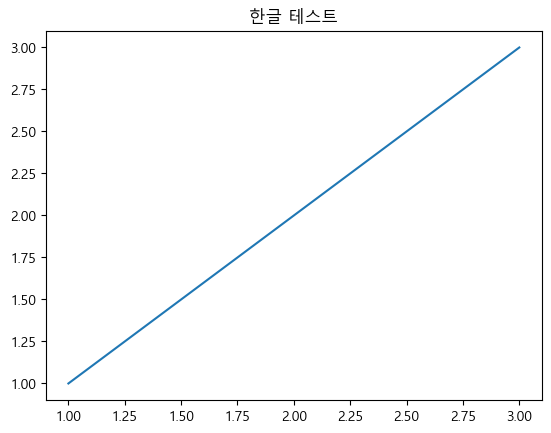

In [13]:
# 한글 폰트 설정 (Windows는 'Malgun Gothic', Mac은 'AppleGothic', Ubuntu는 'NanumGothic' 등)
plt.rc('font', family='Malgun Gothic')  # Windows의 경우

# 한글이 깨지지 않도록 마이너스 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 테스트 그래프
plt.plot([1, 2, 3], [1, 2, 3])
plt.title("한글 테스트")  # 한글이 깨지지 않는지 확인
plt.show()

In [5]:
# 데이터 경로 설정
train_images = [
    "F:/1.Training/원천데이터/a1.생장길이",
    "F:/1.Training/원천데이터/a2.화방높이",
    "F:/1.Training/원천데이터/a3.줄기두께",
    "F:/1.Training/원천데이터/a4.엽장엽폭",
    "F:/1.Training/원천데이터/b.개화군",
    "F:/1.Training/원천데이터/c.착과군",
    "F:/1.Training/원천데이터/d1.꽃(개화군)",
    "F:/1.Training/원천데이터/d2.꽃(착과군)",
    "F:/1.Training/원천데이터/e.열매",
    "F:/1.Training/원천데이터/f.만개꽃"
]

train_labels = [
    "F:/1.Training/라벨링데이터/a1.생장길이",
    "F:/1.Training/라벨링데이터/a2.화방높이",
    "F:/1.Training/라벨링데이터/a3.줄기두께",
    "F:/1.Training/라벨링데이터/a4.엽장엽폭",
    "F:/1.Training/라벨링데이터/b.개화군",
    "F:/1.Training/라벨링데이터/c.착과군",
    "F:/1.Training/라벨링데이터/d1.꽃(개화군)",
    "F:/1.Training/라벨링데이터/d2.꽃(착과군)",
    "F:/1.Training/라벨링데이터/e.열매",
    "F:/1.Training/라벨링데이터/f.만개꽃"
]

val_images = [
    "F:/2.Validation/원천데이터/a1.생장길이",
    "F:/2.Validation/원천데이터/a2.화방높이",
    "F:/2.Validation/원천데이터/a3.줄기두께",
    "F:/2.Validation/원천데이터/a4.엽장엽폭",
    "F:/2.Validation/원천데이터/b.개화군",
    "F:/2.Validation/원천데이터/c.착과군",
    "F:/2.Validation/원천데이터/d1.꽃(개화군)",
    "F:/2.Validation/원천데이터/d2.꽃(착과군)",
    "F:/2.Validation/원천데이터/e.열매",
    "F:/2.Validation/원천데이터/f.만개꽃"
]

val_labels = [
    "F:/2.Validation/라벨링데이터/a1.생장길이",
    "F:/2.Validation/라벨링데이터/a2.화방높이",
    "F:/2.Validation/라벨링데이터/a3.줄기두께",
    "F:/2.Validation/라벨링데이터/a4.엽장엽폭",
    "F:/2.Validation/라벨링데이터/b.개화군",
    "F:/2.Validation/라벨링데이터/c.착과군",
    "F:/2.Validation/라벨링데이터/d1.꽃(개화군)",
    "F:/2.Validation/라벨링데이터/d2.꽃(착과군)",
    "F:/2.Validation/라벨링데이터/e.열매",
    "F:/2.Validation/라벨링데이터/f.만개꽃"
]

In [6]:
# 데이터 전처리
datagen = ImageDataGenerator(rescale=1./255) #픽셀 값을 [0,1] 범위로 정규화
train_generator = datagen.flow_from_directory(
    directory='F:/1.Training/원천데이터',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = datagen.flow_from_directory(
    directory='F:/2.Validation/원천데이터',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 146370 images belonging to 10 classes.
Found 41820 images belonging to 10 classes.


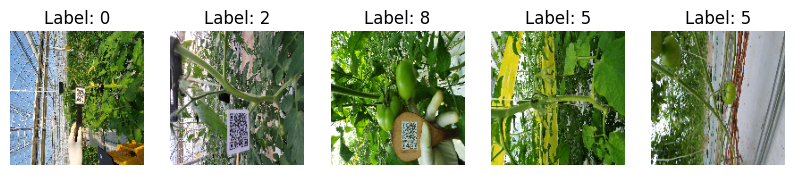

In [7]:
# 이미지 확인하기 (첫 번째 배치에서 이미지 5개를 시각화)
def show_sample_images(generator, num_images=5):
    images, labels = next(generator)  # 첫 번째 배치에서 데이터를 가져옴
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()
    
# 학습용 이미지 출력
show_sample_images(train_generator)


In [8]:
# 모델 구축
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 얼리스타핑 콜백 설정 (validation loss가 3번 연속 향상되지 않으면 훈련 중단)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping])

# 모델 저장
model.save('tomato_growth_model.h5')


Epoch 1/10
   9/4575 [..............................] - ETA: 2:19:42 - loss: 2.4462 - accuracy: 0.3368

KeyboardInterrupt: 

1/1 [==============================] - 0s 68ms/step


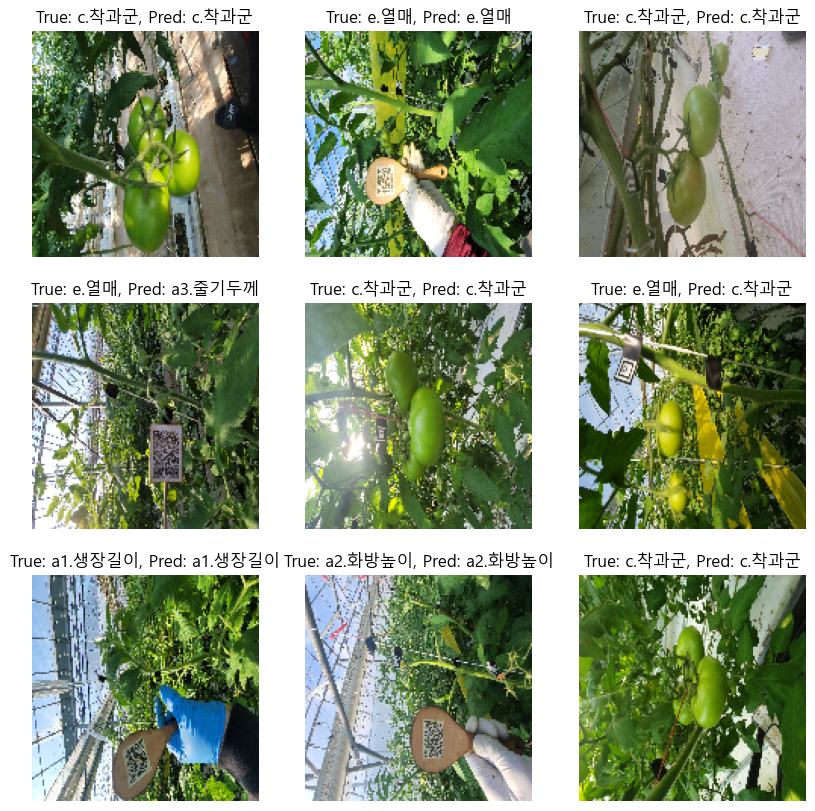

In [14]:
# 저장된 모델 불러오기
model = load_model('tomato_growth_model.h5')

# 이미지를 시각화하고, 예측 레이블과 실제 레이블을 비교하는 함수
def plot_images_with_predictions(test_generator, model, class_labels):
    # 테스트 데이터에서 배치 단위로 이미지와 라벨을 가져옴
    test_images, test_labels = next(test_generator)
    
    # 모델이 해당 이미지들에 대해 예측
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # 실제 라벨과 예측 라벨 시각화를 위한 레이블 인덱스
    true_classes = np.argmax(test_labels, axis=1)

    # 9개의 이미지를 출력하기 위한 설정
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"True: {class_labels[true_classes[i]]}, Pred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
    
    plt.show()

# 클래스 레이블 목록 (클래스명 리스트)
class_labels = list(train_generator.class_indices.keys())

# 시각화 함수 실행 (테스트 이미지 배치와 모델 예측 결과를 시각화)
plot_images_with_predictions(validation_generator, model, class_labels)
